In [19]:
import numpy as np
# !pip install pydot
# !pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=226aaa06e288ba85245c9d2870cb636f721b34ee1bd268be87badfa1f8340b61
  Stored in directory: c:\users\vidyasagar\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [4]:
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2DTranspose
from keras.layers import Input, Add, Dropout, Permute, add

In [5]:
from scipy.io import loadmat

In [6]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [7]:
def FCN_8_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
        
    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))
      
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
    
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    #print(Conv_size)
    
    model.add(Conv2DTranspose(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    #print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    #print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    
    return model
    
    

In [8]:
output = FCN_8_helper(512)
print(len(output.layers))

24


In [9]:
output.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 512, 512, 3)       0         
                                                                 
 conv1_1 (Conv2D)            (None, 512, 512, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 512, 512, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 256, 256, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 256, 256, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 256, 256, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 128, 128, 128)     0

In [10]:
def FCN_8(image_size):
    fcn_8 = FCN_8_helper(image_size)
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_8.layers[-1].output_shape[2] 
    
    #Conv to be applied on Pool4
    skip_con1 = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con1(fcn_8.layers[14].output),fcn_8.layers[-1].output])
    
    #Upsampling output of first skip connection
    x = Conv2DTranspose(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(Summed)
    x = Cropping2D(cropping=((0,2),(0,2)))(x)
    
    
    #Conv to be applied to pool3
    skip_con2 = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")
    
    #Adding skip connection which takes output og Max pooling layer 3 to current layer
    Summed = add(inputs = [skip_con2(fcn_8.layers[10].output),x])
    
    #Final Up convolution which restores the original image size
    Up = Conv2DTranspose(21,kernel_size=(16,16),strides = (8,8),
                         padding = "valid",activation = None,name = "upsample")(Summed)
    
    #Cropping the extra part obtained due to transpose convolution
    final = Cropping2D(cropping = ((0,8),(0,8)))(Up)
    
    
    return Model(fcn_8.input, final)

In [11]:
model = FCN_8(512)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 permute_1_input (InputLayer)   [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 permute_1 (Permute)            (None, 512, 512, 3)  0           ['permute_1_input[0][0]']        
                                                                                                  
 conv1_1 (Conv2D)               (None, 512, 512, 64  1792        ['permute_1[0][0]']              
                                )                                                                 
                                                                                              

                                )                                                                 
                                                                                                  
Total params: 134,489,822
Trainable params: 134,489,822
Non-trainable params: 0
__________________________________________________________________________________________________


In [13]:
from keras.utils import plot_model

In [16]:
plot_model(model,"FCN-8with_shapes.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
#Loading weights from matlab file
data = loadmat('pascal-fcn8s-dag.mat', matlab_compatible=False, struct_as_record=False)
layers = data['layers']
params = data['params']
description = data['meta'][0,0].classes[0,0].description

In [23]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'vars', 'params', 'layers', 'meta'])


In [24]:
print(layers.shape)

(1, 46)


In [25]:
#Inspecting layer names given in .mat file
for i in range(layers.shape[1]):
    print(i,
          str(layers[0,i].name[0]), str(layers[0,i].type[0]),
          [str(n[0]) for n in layers[0,i].inputs[0,:]],
          [str(n[0]) for n in layers[0,i].outputs[0,:]])

0 conv1_1 dagnn.Conv ['data'] ['conv1_1']
1 relu1_1 dagnn.ReLU ['conv1_1'] ['conv1_1x']
2 conv1_2 dagnn.Conv ['conv1_1x'] ['conv1_2']
3 relu1_2 dagnn.ReLU ['conv1_2'] ['conv1_2x']
4 pool1 dagnn.Pooling ['conv1_2x'] ['pool1']
5 conv2_1 dagnn.Conv ['pool1'] ['conv2_1']
6 relu2_1 dagnn.ReLU ['conv2_1'] ['conv2_1x']
7 conv2_2 dagnn.Conv ['conv2_1x'] ['conv2_2']
8 relu2_2 dagnn.ReLU ['conv2_2'] ['conv2_2x']
9 pool2 dagnn.Pooling ['conv2_2x'] ['pool2']
10 conv3_1 dagnn.Conv ['pool2'] ['conv3_1']
11 relu3_1 dagnn.ReLU ['conv3_1'] ['conv3_1x']
12 conv3_2 dagnn.Conv ['conv3_1x'] ['conv3_2']
13 relu3_2 dagnn.ReLU ['conv3_2'] ['conv3_2x']
14 conv3_3 dagnn.Conv ['conv3_2x'] ['conv3_3']
15 relu3_3 dagnn.ReLU ['conv3_3'] ['conv3_3x']
16 pool3 dagnn.Pooling ['conv3_3x'] ['pool3']
17 conv4_1 dagnn.Conv ['pool3'] ['conv4_1']
18 relu4_1 dagnn.ReLU ['conv4_1'] ['conv4_1x']
19 conv4_2 dagnn.Conv ['conv4_1x'] ['conv4_2']
20 relu4_2 dagnn.ReLU ['conv4_2'] ['conv4_2x']
21 conv4_3 dagnn.Conv ['conv4_2x'] ['co

In [26]:
#Inspecting filter and bias sizes 
for i in range(0, params.shape[1]-1, 2):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape,
          str(params[0,i+1].name[0]), params[0,i+1].value.shape)

0 conv1_1_filter (3, 3, 3, 64) conv1_1_bias (64, 1)
2 conv1_2_filter (3, 3, 64, 64) conv1_2_bias (64, 1)
4 conv2_1_filter (3, 3, 64, 128) conv2_1_bias (128, 1)
6 conv2_2_filter (3, 3, 128, 128) conv2_2_bias (128, 1)
8 conv3_1_filter (3, 3, 128, 256) conv3_1_bias (256, 1)
10 conv3_2_filter (3, 3, 256, 256) conv3_2_bias (256, 1)
12 conv3_3_filter (3, 3, 256, 256) conv3_3_bias (256, 1)
14 conv4_1_filter (3, 3, 256, 512) conv4_1_bias (512, 1)
16 conv4_2_filter (3, 3, 512, 512) conv4_2_bias (512, 1)
18 conv4_3_filter (3, 3, 512, 512) conv4_3_bias (512, 1)
20 conv5_1_filter (3, 3, 512, 512) conv5_1_bias (512, 1)
22 conv5_2_filter (3, 3, 512, 512) conv5_2_bias (512, 1)
24 conv5_3_filter (3, 3, 512, 512) conv5_3_bias (512, 1)
26 fc6_filter (7, 7, 512, 4096) fc6_bias (4096, 1)
28 fc7_filter (1, 1, 4096, 4096) fc7_bias (4096, 1)
30 score_fr_filter (1, 1, 4096, 21) score_fr_bias (21, 1)
32 score2_filter (4, 4, 21, 21) score2_bias (21, 1)
34 score_pool4_filter (1, 1, 512, 21) score_pool4_bias (21,

In [27]:
params.shape

(1, 40)

In [28]:
for i in range(0, params.shape[1]):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape)

0 conv1_1_filter (3, 3, 3, 64)
1 conv1_1_bias (64, 1)
2 conv1_2_filter (3, 3, 64, 64)
3 conv1_2_bias (64, 1)
4 conv2_1_filter (3, 3, 64, 128)
5 conv2_1_bias (128, 1)
6 conv2_2_filter (3, 3, 128, 128)
7 conv2_2_bias (128, 1)
8 conv3_1_filter (3, 3, 128, 256)
9 conv3_1_bias (256, 1)
10 conv3_2_filter (3, 3, 256, 256)
11 conv3_2_bias (256, 1)
12 conv3_3_filter (3, 3, 256, 256)
13 conv3_3_bias (256, 1)
14 conv4_1_filter (3, 3, 256, 512)
15 conv4_1_bias (512, 1)
16 conv4_2_filter (3, 3, 512, 512)
17 conv4_2_bias (512, 1)
18 conv4_3_filter (3, 3, 512, 512)
19 conv4_3_bias (512, 1)
20 conv5_1_filter (3, 3, 512, 512)
21 conv5_1_bias (512, 1)
22 conv5_2_filter (3, 3, 512, 512)
23 conv5_2_bias (512, 1)
24 conv5_3_filter (3, 3, 512, 512)
25 conv5_3_bias (512, 1)
26 fc6_filter (7, 7, 512, 4096)
27 fc6_bias (4096, 1)
28 fc7_filter (1, 1, 4096, 4096)
29 fc7_bias (4096, 1)
30 score_fr_filter (1, 1, 4096, 21)
31 score_fr_bias (21, 1)
32 score2_filter (4, 4, 21, 21)
33 score2_bias (21, 1)
34 score_pool

In [29]:
#Note : We are not transfering the weights of score4, score_pool3 and upsample because it doesn't follow the same 
# convention. The weights and biases for them are transferred below seperately

def copy_mat_of_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, 35, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            print(matname)
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            print(f_l_weights.shape)
            print("layer")
            print(kmodel.layers[kindex].get_weights()[0].shape)
            print("layer")
            assert (l_bias.shape[1] == 1)
            print(l_bias[:,0].shape)
            print("bias")
            print(kmodel.layers[kindex].get_weights()[1].shape)
            print("bias")
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))
    return kmodel

In [30]:
model = copy_mat_of_keras(model)

conv1_1
found :  ('conv1_1', 2)
(3, 3, 3, 64) (3, 3, 3, 64)
(3, 3, 3, 64)
layer
(3, 3, 3, 64)
layer
(64,)
bias
(64,)
bias
conv1_2
found :  ('conv1_2', 3)
(3, 3, 64, 64) (3, 3, 64, 64)
(3, 3, 64, 64)
layer
(3, 3, 64, 64)
layer
(64,)
bias
(64,)
bias
conv2_1
found :  ('conv2_1', 5)
(3, 3, 64, 128) (3, 3, 64, 128)
(3, 3, 64, 128)
layer
(3, 3, 64, 128)
layer
(128,)
bias
(128,)
bias
conv2_2
found :  ('conv2_2', 6)
(3, 3, 128, 128) (3, 3, 128, 128)
(3, 3, 128, 128)
layer
(3, 3, 128, 128)
layer
(128,)
bias
(128,)
bias
conv3_1
found :  ('conv3_1', 8)
(3, 3, 128, 256) (3, 3, 128, 256)
(3, 3, 128, 256)
layer
(3, 3, 128, 256)
layer
(256,)
bias
(256,)
bias
conv3_2
found :  ('conv3_2', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
(3, 3, 256, 256)
layer
(3, 3, 256, 256)
layer
(256,)
bias
(256,)
bias
conv3_3
found :  ('conv3_3', 10)
(3, 3, 256, 256) (3, 3, 256, 256)
(3, 3, 256, 256)
layer
(3, 3, 256, 256)
layer
(256,)
bias
(256,)
bias
conv4_1
found :  ('conv4_1', 12)
(3, 3, 256, 512) (3, 3, 256, 512)
(3, 3, 2

In [31]:
kerasnames = [lr.name for lr in model.layers]

In [32]:
kerasnames

['permute_1_input',
 'permute_1',
 'conv1_1',
 'conv1_2',
 'pool1',
 'conv2_1',
 'conv2_2',
 'pool2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'pool3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'pool4',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'pool5',
 'fc6',
 'fc7',
 'score_fr',
 'score2',
 'score_pool4',
 'cropping2d_1',
 'add',
 'score4',
 'score_pool3',
 'cropping2d_2',
 'add_1',
 'upsample',
 'cropping2d_3']

In [33]:
#Getting the index of layer by name
kindex = kerasnames.index('score4')

In [34]:
kindex

27

In [35]:
l_weights = params[0,36].value

In [36]:
l_weights.shape

(4, 4, 21, 21)

In [37]:
bias = np.zeros(21)

In [38]:
#Giving weights and bias to corresponding layer
#Note : Bias is given as zero as it is absent in the .mat file
model.layers[27].set_weights([l_weights,bias])

In [39]:
#Getting the index of layer by name
kindex = kerasnames.index('score_pool3')

In [40]:
kindex

28

In [41]:
l_weights = params[0,37].value

In [42]:
l_weights.shape

(1, 1, 256, 21)

In [43]:
bias = params[0,38].value

In [44]:
bias.shape

(21, 1)

In [45]:
bias = bias[:,0]

In [46]:
bias.shape

(21,)

In [47]:
#Giving weights and bias to corresponding layer
model.layers[28].set_weights([l_weights,bias])

In [48]:
#Getting the index of layer by name
kindex = kerasnames.index('upsample')

In [49]:
kindex

31

In [50]:
lweights = params[0,39].value

In [51]:
lweights.shape

(16, 16, 21, 21)

In [52]:
bias = np.zeros(21)

In [53]:
#Giving weights and bias to corresponding layer
#Note : Bias is given as zero as it is absent in the .mat file
model.layers[31].set_weights([lweights,bias])

In [54]:
from skimage.io import imread, imsave

In [55]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [97]:
im = Image.open('TestImages/2007_000033.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


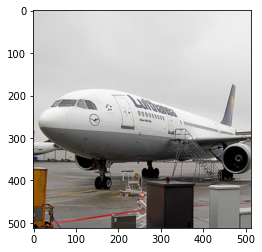

In [98]:
plt.imshow(np.asarray(im))
plt.imsave("orginal_1.png",im)
print(np.asarray(im).shape)

In [99]:
import copy
import math

In [100]:
def prediction(kmodel, crpimg, transform=False):
	# INFO : crpimg should be a cropped image of the right dimension


	imarr = np.array(crpimg).astype(np.float32)

	if transform:
		imarr[:, :, 0] -= 129.1863
		imarr[:, :, 1] -= 104.7624
		imarr[:, :, 2] -= 93.5940
		
		aux = copy.copy(imarr)
		imarr[:, :, 0] = aux[:, :, 2]
		imarr[:, :, 2] = aux[:, :, 0]

	# imarr[:,:,0] -= 129.1863
	# imarr[:,:,1] -= 104.7624
	# imarr[:,:,2] -= 93.5940

	# imarr = imarr.transpose((2, 0, 1))
	imarr = np.expand_dims(imarr, axis=0)

	return kmodel.predict(imarr)

In [101]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

1/1 [==============================] - 2s 2s/step


(1, 512, 512, 21)
<class 'numpy.ndarray'>
512
(512, 512)
(512, 512)


C:\Users\Vidyasagar\AppData\Local\Temp\ipykernel_15788\1346019622.py:5: UserWarning: annotation1_fcn8.png is a low contrast image
  imsave("annotation1_fcn8.png",imclass)


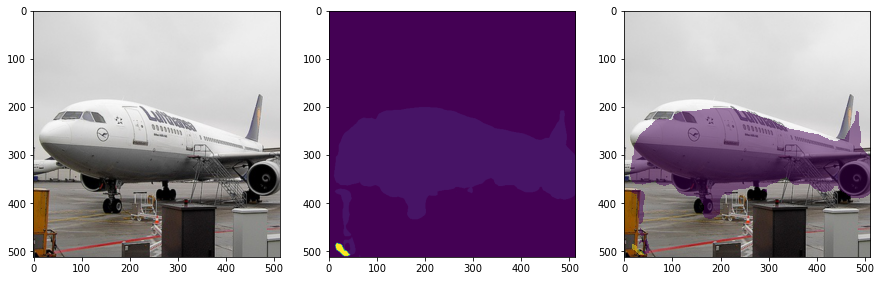

In [102]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
imclass = imclass.astype(np.uint8)
imsave("annotation1_fcn8.png",imclass)
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [103]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

0 background
1 aeroplane
9 chair
19 train


In [104]:
im = Image.open('TestImages/2007_000032.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


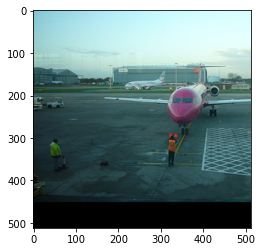

In [105]:
plt.imshow(np.asarray(im))
plt.imsave("orginal2.png",im)
print(np.asarray(im).shape)

In [106]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

1/1 [==============================] - 1s 1s/step


(1, 512, 512, 21)
<class 'numpy.ndarray'>
512
(512, 512)
(512, 512)


C:\Users\Vidyasagar\AppData\Local\Temp\ipykernel_15788\2469063557.py:6: UserWarning: annotation2_fcn8.png is a low contrast image
  imsave("annotation2_fcn8.png",imclass)


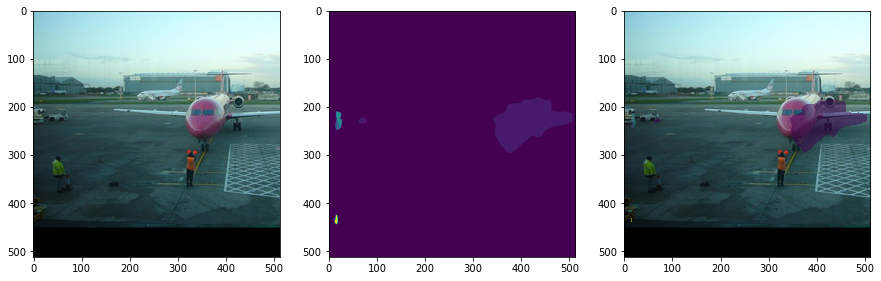

In [107]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(type(imclass))
print(len(imclass))
imclass = imclass.astype(np.uint8)
imsave("annotation2_fcn8.png",imclass)
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [108]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

0 background
1 aeroplane
4 boat
7 car
14 motorbike


In [109]:
im = Image.open('TestImages/rgb.jpg') 
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((512,512))

(512, 512, 3)


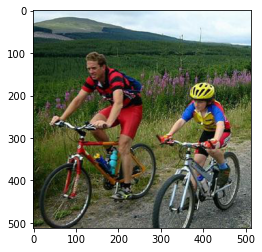

In [111]:
plt.imshow(np.asarray(im))
plt.imsave("orginal3.png",im)
print(np.asarray(im).shape)

In [112]:
crpim = im 
preds = prediction(model, crpim, transform=False) 

1/1 [==============================] - 1s 1s/step


(1, 512, 512, 21)
<class 'numpy.ndarray'>
512
(512, 512)
(512, 512)


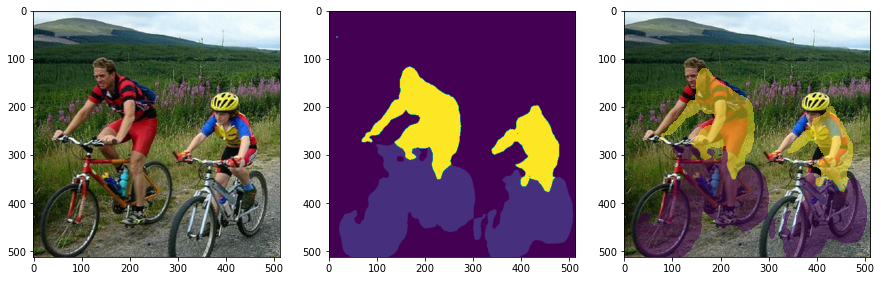

In [113]:
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
imclass = imclass.astype(np.uint8)
imsave("annotation3_fcn8.png",imclass)
print(type(imclass))
print(len(imclass))
print(imclass.shape)
print(imclass.shape)

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [89]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

0 background
2 bicycle
11 diningtable
15 person
